### Import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import math
from scipy.special import expit
from scipy.special import softmax as smax

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time

from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


### Fetch the MNIST dataset from sklearn datasets module

In [2]:
data_set = datasets.fetch_openml("mnist_784", version=1, return_X_y = True)
pixel_values, targets = data_set

### Visualiszing the first digit

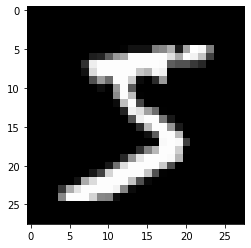

True Label associated with it = 5


In [3]:
#visualizing one single digit
single_digit = pixel_values[0,:].reshape(28,28)
plt.imshow(single_digit, cmap='gray')
plt.show()
#the corresponing true label
print("True Label associated with it =",targets[0])

### Preprocessing the dataset

In [4]:
#since targets are of string type, we convert them into integers
y_int = targets.astype(int)
#now converting to one hot encoded arrays
y = to_categorical(y_int)

#normalize  and convert type to float 32
x = (pixel_values/255)
print(x.shape)
print(y.shape)


(70000, 784)
(70000, 10)


### splitting into training, validation, and testing data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.06, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.08, random_state=42)

#reshaping
x_train = x_train.T
x_test = x_test.T
x_val = x_val.T
y_train = y_train.T
y_test = y_test.T
y_val = y_val.T


print("X train shape",x_train.shape)
print("Y train shape",y_train.shape)
print("X val shape",x_val.shape)
print("Y val shape",y_val.shape)
print("X test shape",x_test.shape)
print("Y test shape",y_test.shape)

X train shape (784, 60536)
Y train shape (10, 60536)
X val shape (784, 5264)
Y val shape (10, 5264)
X test shape (784, 4200)
Y test shape (10, 4200)


### Creating a Deep Neural Network class

In [12]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.05, gamma=0.9, batch_size = 64):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.gamma = gamma 
        self.batch_size = batch_size 
        
        # we save all parameters in the neural network in this dictionary
        self.params, self.momenta = self.initialization()

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer1=self.sizes[1]
        hidden_layer2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            "W1" : np.random.randn(hidden_layer1, input_layer)*np.sqrt(1. / hidden_layer1),
            "W2" : np.random.randn(hidden_layer2, hidden_layer1)*np.sqrt(1. / hidden_layer2),
            "W3" : np.random.randn(output_layer, hidden_layer2)*np.sqrt(1. / output_layer),
            "B1" : np.zeros((hidden_layer1,1), np.float32),
            "B2" : np.zeros((hidden_layer2,1), np.float32),
            "B3" : np.zeros((output_layer,1), np.float32),
        }
        
        momenta = {
            "W1" : np.zeros(params["W1"].shape),
            "W2" : np.zeros(params["W2"].shape),
            "W3" : np.zeros(params["W3"].shape),
            "B1" : np.zeros(params["B1"].shape),
            "B2" : np.zeros(params["B2"].shape),
            "B3" : np.zeros(params["B3"].shape)
        }
        return params, momenta
    
    def compute_loss(self, y, y_hat):
        L_sum = np.sum(np.multiply(y, np.log(y_hat)))
        m = y.shape[1]
        L = -(1./m) * L_sum
        return L
    
    def sigmoid(self, x, derivative=False):
        #using the expit function from scipy
        if derivative:
            return  (self.sigmoid(x,False))*(1 - self.sigmoid(x,False))
        return expit(x)
    
    def tanh(self, x, derivative=False):
        if derivative:
            tanh_x = self.tanh(x)
            return (1-tanh_x*tanh_x)
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def softmax(self, x):
        return smax(x, axis=0)
        #return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def forward_pass(self, x_train):
        params = self.params
        
        #for layer 1 to l-1, i.e., till one but last layer, get the outputs
        #h0 is the input itself
        params["H0"] = x_train
        
        # input layer to hidden layer 1
        params["A1"] = np.matmul(params["W1"], params["H0"]) + params["B1"]
        params["H1"] = self.sigmoid(params["A1"])

        # hidden layer 1 to hidden layer 2
        params["A2"] = np.matmul(params["W2"], params["H1"]) + params["B2"]
        params["H2"] = self.sigmoid(params["A2"])

        # hidden layer 2 to output layer
        params["A3"] = np.matmul(params["W3"], params["H2"]) + params["B3"]
        params["H3"] = self.softmax(params["A3"])
                
        #return the predicted out that is H3
        return params["H3"]
    
    def backward_pass(self, y_train, output):
        
        #Back Propagation to learn the weights and biases
        #we will get the output from the forward pass
        params = self.params
        change_w = {}
        n_samples = y_train.shape[1]
        
        # Calculate W3 update
        error = output - y_train
        change_w['W3'] = (1./n_samples) * np.matmul(error, params["H2"].T)
        change_w['B3'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)

        # Calculate W2 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.matmul(params["W3"].T,error), self.sigmoid(params["A2"], derivative=True))
        change_w['W2'] = (1./n_samples) * np.matmul(error, params["H1"].T)
        change_w['B2'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)

        # Calculate W1 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.matmul(params["W2"].T,error), self.sigmoid(params["A1"], derivative=True))
        change_w['W1'] = (1./n_samples) * np.matmul(error, params["H0"].T)
        change_w['B1'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)
        
        return change_w
    
    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.momenta[key] = (self.l_rate * value) + (self.gamma * self.momenta[key])
            self.params[key] = self.params[key] - self.momenta[key]
    
    def get_lookahead_parameters(self):
        params_og = {}
        for key, value in self.momenta.items():
            params_og[key] = self.params[key]
            self.params[key] = self.params[key] - (self.gamma * self.momenta[key])
        return params_og
    
    def get_og_params(self, params_og):
        for key, value in params_og.items():
            self.params[key] = value
    
    def compute_accuracy(self, x_val, y_val):
        output = self.forward_pass(x_val)
        pred = np.argmax(output,axis=0)
        actual = np.argmax(y_val,axis=0)
        predictions = (actual == pred)
        return np.average(predictions)
    
    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            
            batches = math.ceil(x_train.shape[1]/self.batch_size)
            for j in range(batches):
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[1])
                
                x_mini = x_train[:, begin:end]
                y_mini = y_train[:, begin:end]
                
                params_og = self.get_lookahead_parameters()
                
                output = self.forward_pass(x_mini)
            
                changes_to_w = self.backward_pass(y_mini, output)
                
                self.get_og_params(params_og) #setting the weights and biases to original
                
                #update after one pass on a mini batch
                self.update_network_parameters(changes_to_w)
            
            train_ouput = self.forward_pass(x_train)
            train_cost = self.compute_loss(y_train, train_ouput)
            val_ouput = self.forward_pass(x_val)
            val_cost = self.compute_loss(y_val, val_ouput)
            print("Epoch {}: Training cost = {}, Validation cost = {}".format(iteration+1 ,train_cost, val_cost))
        end_time = time.time()
        print("Total time taken for {} epochs is {}".format(self.epochs,end_time-start_time))

In [13]:
#training and validating
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch 1: Training cost = 0.25618417329028054, Validation cost = 0.25824970474547365
Epoch 2: Training cost = 0.17943576921392007, Validation cost = 0.183827598518314
Epoch 3: Training cost = 0.13637107621970326, Validation cost = 0.14523172175979998
Epoch 4: Training cost = 0.10811081669030358, Validation cost = 0.12190651276886957
Epoch 5: Training cost = 0.08844926238702663, Validation cost = 0.10719557705689702
Epoch 6: Training cost = 0.0740042253775178, Validation cost = 0.09742874064688778
Epoch 7: Training cost = 0.06293710871548264, Validation cost = 0.09064372647377829
Epoch 8: Training cost = 0.05409306303277052, Validation cost = 0.08569738258968915
Epoch 9: Training cost = 0.04684126706891818, Validation cost = 0.08199481082660712
Epoch 10: Training cost = 0.040836998935727085, Validation cost = 0.07924192082531366
Total time taken for 10 epochs is 29.900261163711548


### Testing on unseen data

In [14]:
test_output = dnn.forward_pass(x_test)

predictions = np.argmax(test_output, axis=0)
labels = np.argmax(y_test, axis=0)

print(confusion_matrix(predictions, labels))
print("\n\n")
print(classification_report(predictions, labels))

[[416   0   0   1   1   0   3   0   1   1]
 [  0 458   0   1   1   0   0   2   4   3]
 [  1   0 388   6   1   0   1   6   1   0]
 [  0   0   1 451   1   5   0   1   6   2]
 [  0   0   3   0 339   0   1   2   0   2]
 [  0   0   0   4   1 382   5   0   0   1]
 [  2   0   3   0   0   4 405   1   2   0]
 [  0   1   2   3   1   0   0 419   1   3]
 [  0   1   2   3   2   5   2   2 406   4]
 [  0   0   0   1   6   0   0   2   1 413]]



              precision    recall  f1-score   support

           0       0.99      0.98      0.99       423
           1       1.00      0.98      0.99       469
           2       0.97      0.96      0.97       404
           3       0.96      0.97      0.96       467
           4       0.96      0.98      0.97       347
           5       0.96      0.97      0.97       393
           6       0.97      0.97      0.97       417
           7       0.96      0.97      0.97       430
           8       0.96      0.95      0.96       427
           9       0.96  

In [15]:
testing_accuracy = dnn.compute_accuracy(x_test,y_test)
print("Accuracy on Test Set =",testing_accuracy)

Accuracy on Test Set = 0.9707142857142858
